<a href="https://colab.research.google.com/github/Tensor-Reloaded/Advanced-Topics-in-Neural-Networks-Template-2023/blob/main/Lab03/TensorOperations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import Tensor
from time import time
import gc
from typing import Union, Tuple
from functools import wraps, partial
import cv2 as cv

# Advanced tensor operations

### Measuring

PyTorch has it's own benchmark system, see https://pytorch.org/tutorials/recipes/recipes/benchmark.html.

For now, we will use a simple one, defined here:

In [ ]:
# This can be used for everything.
def timed(fn):
    @wraps(fn)
    def wrap(*args, **kwargs):
        gc.collect()
        start = time()
        ret = fn(*args, **kwargs)
        end = time()
        sizes = [f"{x.shape}" for x in args if isinstance(x, Tensor)]
        try:
            name = fn.__name__
        except:
            name =  "traced"
        print(name, f"took {end - start} for input of size", ", ".join(sizes))
        return ret
    return wrap

In [2]:
# Better, but is meant to be used with pytorch and cuda
def timed(fn):
    @wraps(fn)
    def wrap(*args, **kwargs):
        gc.collect()
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        ret = fn(*args, **kwargs)
        end.record()
        torch.cuda.synchronize()
        sizes = [f"{x.shape}" for x in args if isinstance(x, Tensor)]
        try:
            name = fn.__name__
        except:
            name =  "traced"
        print(name, f"took {start.elapsed_time(end)} for input of size", ", ".join(sizes))
        return ret
    return wrap

## Batching guidelines

PyTorch works with batches. Use batched operations, it's (almost) always than using single items.

In [ ]:
# Example, good
def batched_processing(x):
    pass  # Do stuff with batch x


def single_item_processing(x):
    return batched_processing([x])

Doing single item processing disables vectorization and built-in parallelization.

In [ ]:
# Example, bad
def single_item_processing(x):
    pass  # Do stuff with element x


def batched_processing(x):
    return [single_item_processing(i) for i in x]

## Example 1

In [ ]:
@timed
def single_item_exp(batch: Tensor):
    for x in batch:
        x.exp()


@timed
def batched_exp(batch: Tensor):
    batch.exp()


tensor_1 = torch.rand((5000))
tensor_2 = torch.rand((10000))
tensor_3 = torch.rand((20000))

print("O(n)")
single_item_exp(tensor_1)
single_item_exp(tensor_2)
single_item_exp(tensor_3)

print("\nWe do not see the linear increase until we reach the hardware parallelization capacity")
batched_exp(tensor_1)
batched_exp(tensor_2)
batched_exp(tensor_3)
batched_exp(torch.rand((20000 * 10)))
batched_exp(torch.rand((20000 * 100)))

del tensor_1, tensor_2, tensor_3

O(n)
single_item_exp took 20.698944091796875 for input of size torch.Size([5000])
single_item_exp took 42.33881759643555 for input of size torch.Size([10000])
single_item_exp took 78.76201629638672 for input of size torch.Size([20000])

We do not see the linear increase until we reach the hardware parallelization capacity
batched_exp took 0.46025601029396057 for input of size torch.Size([5000])
batched_exp took 0.13606399297714233 for input of size torch.Size([10000])
batched_exp took 1.300544023513794 for input of size torch.Size([20000])
batched_exp took 0.30297601222991943 for input of size torch.Size([200000])
batched_exp took 7.065631866455078 for input of size torch.Size([2000000])


## Example 2

In [ ]:
@timed
def single_item_softmax(batch: Tensor):
    for x in batch:
        x.softmax(dim=0)


@timed
def batched_softmax(batch: Tensor):
    batch.softmax(dim=1)


tensor_1 = torch.rand((1000, 500))
tensor_2 = torch.rand((5000, 500))
tensor_3 = torch.rand((10000, 500))

single_item_softmax(tensor_1)
single_item_softmax(tensor_2)
single_item_softmax(tensor_3)

batched_softmax(tensor_1)
batched_softmax(tensor_2)
batched_softmax(tensor_3)

assert torch.isclose(tensor_1[0].softmax(dim=0), tensor_1.softmax(dim=1)[0]).all()

del tensor_1, tensor_2, tensor_3

single_item_softmax took 18.467391967773438 for input of size torch.Size([1000, 500])
single_item_softmax took 31.25315284729004 for input of size torch.Size([5000, 500])
single_item_softmax took 61.12665557861328 for input of size torch.Size([10000, 500])
batched_softmax took 1.1716159582138062 for input of size torch.Size([1000, 500])
batched_softmax took 11.951904296875 for input of size torch.Size([5000, 500])
batched_softmax took 18.7992000579834 for input of size torch.Size([10000, 500])


## Inplace operations

General guideline: Most inplace operations are faster because they avoid memory allocation.
However, the PyTorch Autograd Engine might complain when asked to compute gradients for inplace operations. So always check if the forward and backward step works when using inplace operations.

In [ ]:
@timed
def add(x: Tensor, y: Tensor):
    x = x + y


@timed
def add_(x: Tensor, y: Tensor):
    x += y


@timed
def abs(x: Tensor):
    x = x.abs()


@timed
def abs_(x: Tensor):
    x.abs_()


tensor_1 = torch.rand((1000, 5000))
tensor_2 = torch.rand((1000, 5000))


add(tensor_1, tensor_2)
add_(tensor_1, tensor_2)
abs(tensor_1)
abs_(tensor_1)

del tensor_1, tensor_2

add took 11.1560640335083 for input of size torch.Size([1000, 5000]), torch.Size([1000, 5000])
add_ took 3.661504030227661 for input of size torch.Size([1000, 5000]), torch.Size([1000, 5000])
abs took 3.396928071975708 for input of size torch.Size([1000, 5000])
abs_ took 2.056256055831909 for input of size torch.Size([1000, 5000])


## Case study

Write a function that receives a batch of gradients (Tensor of shape [B, N, M]) and returns all gradients whose norm are within one standard deviations from mean of all norms. If no gradient has the norm within 1.5 standard deviations from the mean, return None.

In [3]:
@timed
def get_normal_tensors_1(x: Tensor) -> Union[Tensor, None]:
    norms = x.norm(dim=(1, 2))
    mean = torch.mean(norms)
    std = torch.std(norms)
    mask_1 = norms < mean + std
    mask_2 = norms > mean - std
    mask = torch.logical_and(mask_1, mask_2)
    return x[mask] if mask.any() else None


@timed
def get_normal_tensors_2(x: Tensor) -> Union[Tensor, None]:
    norms = x.norm(dim=(1, 2))
    std, mean = torch.std_mean(norms)  # computing the mean only once (std requires computing the mean)
    mask_1 = norms < mean + std
    mask_2 = norms > mean - std
    mask = torch.logical_and(mask_1, mask_2)
    return x[mask] if mask.any() else None


@timed
def get_normal_tensors_3(x: Tensor) -> Union[Tensor, None]:
    norms = x.norm(dim=(1, 2))
    std, mean = torch.std_mean(norms)
    # instead of 2 x (single element addition + tensor-element comparison)
    # we do 1 tensor-element addition + 2 x tensor-element comparison
    # (should be slower than 2)
    norms = norms - mean
    mask_1 = norms < std
    mask_2 = norms > -std
    mask = torch.logical_and(mask_1, mask_2)
    return x[mask] if mask.any() else None


@timed
def get_normal_tensors_4(x: Tensor) -> Union[Tensor, None]:
    norms = x.norm(dim=(1, 2))
    std, mean = torch.std_mean(norms)
    # we do the tensor-element addition inplace
    norms -= mean
    mask_1 = norms < std
    mask_2 = norms > -std
    mask = torch.logical_and(mask_1, mask_2)
    return x[mask] if mask.any() else None


@timed
def get_normal_tensors_5(x: Tensor) -> Union[Tensor, None]:
    norms = x.norm(dim=(1, 2))
    std, mean = torch.std_mean(norms)
    # 1 tensor-element addition + 1 tensor abs call + 1 tensor-element comparison
    # we save 1 tensor-element comparison, which is an expensive operation, because the
    # element needs to be broadcasted to the same shape as the tensor (for element-wise comparison)
    # and comparing triggers device side synchronization.
    mask = torch.abs(norms - mean) < std
    return x[mask] if mask.any() else None
    # Can be optimized even further. Try it and measure!


@timed
@partial(torch.jit.trace, example_inputs=(torch.rand((200, 100, 2560)).cuda()))
def get_normal_tensors_5_traced(x: Tensor) -> Tensor:
    # This method is traced and optimized for GPU.
    # It does Just In Time optimization by running the function first with the example_inputs and tracing the execution graph.
    # It then tries to fuse the operations for a faster runtime.
    norms = x.norm(dim=(1, 2))
    std, mean = torch.std_mean(norms)
    mask = torch.abs(norms - mean) < std
    # Warning! Only one execution path is optimized,
    # the one that is triggered by example_inputs.
    # The other execution path will be discarded.
    # Tracing is meant for sequential operations.
    return x[mask] if mask.any() else None


@timed
@torch.compile
def get_normal_tensors_5_compiled(x: Tensor) -> Tensor:
    norms = x.norm(dim=(1, 2))
    std, mean = torch.std_mean(norms)
    mask = torch.abs(norms - mean) < std
    return x[mask] if mask.any() else None


tensor = torch.rand((200, 100, 2560))
r_1 = get_normal_tensors_1(tensor)
r_2 = get_normal_tensors_2(tensor)
r_3 = get_normal_tensors_3(tensor)
r_4 = get_normal_tensors_4(tensor)
r_5 = get_normal_tensors_5(tensor)
r_6 = get_normal_tensors_5_traced(tensor)
r_6 = get_normal_tensors_5_traced(tensor)
r_7 = get_normal_tensors_5_compiled(tensor)
r_7 = get_normal_tensors_5_compiled(tensor)
r_7 = get_normal_tensors_5_compiled(tensor)

print("\nOn cuda:")
cuda_tensor = tensor.to('cuda')
get_normal_tensors_1(cuda_tensor)
get_normal_tensors_2(cuda_tensor)
get_normal_tensors_3(cuda_tensor)
get_normal_tensors_4(cuda_tensor)
get_normal_tensors_5(cuda_tensor)
get_normal_tensors_5_traced(cuda_tensor)
get_normal_tensors_5_traced(cuda_tensor)
get_normal_tensors_5_compiled(cuda_tensor)
get_normal_tensors_5_compiled(cuda_tensor)
get_normal_tensors_5_compiled(cuda_tensor)


assert torch.equal(r_1, r_2)
assert torch.equal(r_1, r_3)
assert torch.equal(r_1, r_4)
assert torch.equal(r_1, r_5)
assert torch.equal(r_1, r_6)
assert torch.equal(r_1, r_7)

<ipython-input-3-63f5d2ab07bd>:67: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return x[mask] if mask.any() else None


get_normal_tensors_1 took 111.15245056152344 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_2 took 82.89596557617188 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_3 took 92.15184020996094 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_4 took 80.97561645507812 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_5 took 85.83977508544922 for input of size torch.Size([200, 100, 2560])
traced took 269.5515441894531 for input of size torch.Size([200, 100, 2560])
traced took 185.59388732910156 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_5_compiled took 9943.3310546875 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_5_compiled took 83.11625671386719 for input of size torch.Size([200, 100, 2560])
get_normal_tensors_5_compiled took 82.79590606689453 for input of size torch.Size([200, 100, 2560])

On cuda:
get_normal_tensors_1 took 35.29993438720703 for input of size torch.Size([200, 10

We use timeit for repeating an experiment multiple times

In [ ]:
%%timeit
get_normal_tensors_1.__wrapped__(tensor)  # initial version

99.1 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_2.__wrapped__(tensor)  # we remove one mean calculation

85.9 ms ± 722 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_3.__wrapped__(tensor)  # we do a tensor-element addition first

91.1 ms ± 8.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_4.__wrapped__(tensor)  # we do the tensor-element addition inplace

85.8 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_5.__wrapped__(tensor)  # we use abs to do only one comparison

92.5 ms ± 8.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_5_traced.__wrapped__(tensor)

87.1 ms ± 4.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_5_compiled.__wrapped__(tensor)

86.4 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
get_normal_tensors_1.__wrapped__(cuda_tensor)

2.05 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
get_normal_tensors_2.__wrapped__(cuda_tensor)

2.04 ms ± 7.64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
get_normal_tensors_3.__wrapped__(cuda_tensor)

2.07 ms ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
get_normal_tensors_4.__wrapped__(cuda_tensor)

2.1 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
get_normal_tensors_5.__wrapped__(cuda_tensor)

2.04 ms ± 9.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
get_normal_tensors_5_traced.__wrapped__(cuda_tensor)

2.02 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
get_normal_tensors_5_compiled.__wrapped__(cuda_tensor)

2.09 ms ± 8.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
del tensor, cuda_tensor

## Excercises

### Excercise 1

Input: two boolean two-dimensional tensors, with shape [N, M], which represent a segmentation prediction and a segmentation ground truth.


In [2]:
x1 = torch.rand((10, 8)) < 0.5
x2 = torch.rand((10, 8)) < 0.5
x1, x2

(tensor([[False, False, False,  True, False,  True,  True, False],
         [ True, False, False,  True, False,  True, False,  True],
         [False,  True,  True,  True,  True,  True, False, False],
         [ True,  True, False, False,  True,  True, False, False],
         [ True, False,  True, False,  True, False,  True, False],
         [ True,  True, False,  True,  True, False, False,  True],
         [ True, False,  True, False,  True, False, False,  True],
         [False,  True,  True, False, False, False,  True, False],
         [ True,  True,  True,  True,  True,  True,  True, False],
         [False,  True, False, False, False, False, False, False]]),
 tensor([[False,  True, False, False, False,  True,  True,  True],
         [False, False, False,  True,  True, False,  True,  True],
         [ True,  True,  True, False,  True, False,  True, False],
         [False, False,  True, False,  True,  True, False, False],
         [False, False, False, False,  True,  True, False, F

a) Calculate the number of $TP$.

In [10]:
def get_tp(x: Tensor, y: Tensor) -> int:
    print(torch.logical_and(x, y))
    return len(torch.logical_and(x, y).nonzero())

get_tp(x1, x2)

tensor([[False, False, False, False, False,  True,  True, False],
        [False, False, False,  True, False, False, False,  True],
        [False,  True,  True, False,  True, False, False, False],
        [False, False, False, False,  True,  True, False, False],
        [False, False, False, False,  True, False, False, False],
        [ True,  True, False, False, False, False, False, False],
        [False, False, False, False,  True, False, False,  True],
        [False, False,  True, False, False, False,  True, False],
        [False, False,  True,  True, False,  True, False, False],
        [False, False, False, False, False, False, False, False]])


19

b) Calculate the number of $TP, FP, FN, TN$.

In [ ]:
def get_tp_fp_fn_tn(x: Tensor, y: Tensor) -> Tuple[int, int, int, int]:
    pass

c) Calculate the dice score (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).

In [ ]:
def dice_score(x: Tensor, y: Tensor) -> Tensor:
    pass

### Excercise 2

Write a function that calculates the batched euclidean distance between two tensors of shape [B1, N], [B2, N], where B1 and B2 are the batch dimensions and N is the number of features.

In [ ]:
def batched_euclidean_distance(x: Tensor, y: Tensor) -> Tensor:
    pass  # your implementation here


a = torch.rand((10, 8))
b = torch.rand((12, 8))
batched_euclidean_distance(a, b)

Start with writing a function that computs the euclidian instance between two vectors:


In [ ]:
def single_element_euclidian_distance(x_i: Tensor, y_i: Tensor) -> Tensor:
    pass  # your implementation here

### Excercise 3:

Working with the test_image.jpg

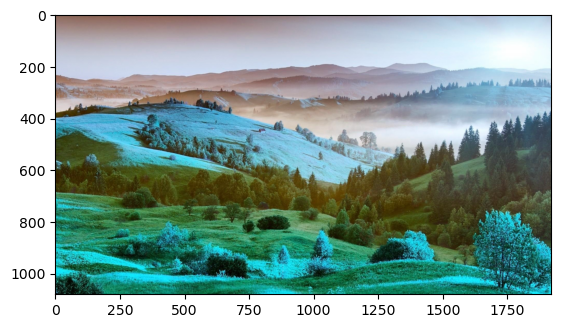

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

img = torch.from_numpy(cv.imread("test_image.jpg"))
plt.imshow(img)
plt.show()

a) Transform the image from the BGR format to the RGB format and display it.

In [ ]:
img_rgb = ...  # your code here


plt.imshow(img_rgb)
plt.show()

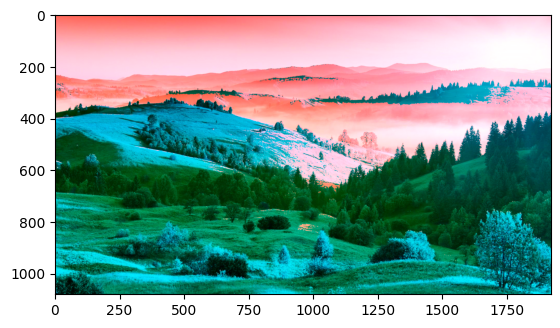

In [ ]:
cloned_img = img.clone()
cloned_img[:, :, 0] = torch.where(cloned_img[:, :, 0] < 255 / 2, 0, 255)
plt.imshow(cloned_img)
plt.show()

b) Transform the image to grayscale using tensor operations.

In [ ]:
img_grayscale = ...  # your code here


plt.imshow(img_grayscale)
plt.show()

c) Crop the top-left corner of the image and display it.

In [ ]:
img_cropped = ...  # your code here


plt.imshow(img_cropped)
plt.show()

d) Set all green pixels to red using basic pytorch operations (Bonus points if done during class).

In [ ]:
img_red = ...  # your code here


plt.imshow(img_red)
plt.show()

e) Add a random noise matrix to the top-left corner of the image, clip the values to 0 and 255 and display it.

In [ ]:
img_noise = ...  # your code here


plt.imshow(img_noise)
plt.show()

f) Write a function that rotates the image 90 degrees and display the rotated image

In [ ]:
def rotate90(x: Tensor) -> Tensor:
    pass

plt.imshow(rotate90(img))
plt.show()